# Jake Vanderplas' Methodology for Git, GitHub, Modules, and Reproducibility
[YouTube video series](https://www.youtube.com/watch?v=_ZEWDGpM-vM&list=PLYCpMb24GpOC704uO9svUrihl-HY1tTJJ)

In [21]:
# use the budget_tool environment in Conda

import os
import pandas as pd

import matplotlib.pyplot as plt

# much nicer style for matplotlib plots
plt.style.use('seaborn')

In [22]:
# function to load the Fremont bike data - will download if it isn't already in the 
# data folder will also create the data folder if it doesn't already exist
def get_fremont_data(url, filename='data/Fremont.csv', force_download=False):
    if force_download or not os.path.exists(filename):
        data = pd.read_csv(URL, index_col='Date', parse_dates=True)
        data.columns = ['Total','East','West']
        if not os.path.exists('data'):
            os.mkdir('data')
        data.to_csv('data/Fremont.csv')
    else:
        data = pd.read_csv('data/Fremont.csv', index_col='Date', parse_dates=True)
    
    return data

In [23]:
# load or download the data directly into dataframe
URL = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
data = get_fremont_data(URL)

In [24]:
# Unix command to see the first 10 lines of the file ("!" indicates that this is a bash command)
!head data/Fremont.csv

Date,Total,East,West
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0
2019-11-01 05:00:00,20.0,9.0,11.0
2019-11-01 06:00:00,97.0,43.0,54.0
2019-11-01 07:00:00,299.0,120.0,179.0
2019-11-01 08:00:00,583.0,261.0,322.0


In [25]:
# this measures the time to execute the whole cell 
#%%timeit -r1 -n1   #set the number and repeats of loops
# use %timeit directyly in front of a specific command (separated by a space) 
# if you want just the command instead of the whole cell

# import and automatically parse the datetime data - this is the slow method, 
# later he teaches how to identify the format which drammatically speeds up the 
# datetime parsing
data = pd.read_csv('data/Fremont.csv', index_col='Date', parse_dates=True)

In [26]:
data.head()

,Total,East,West
Date,,,
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0


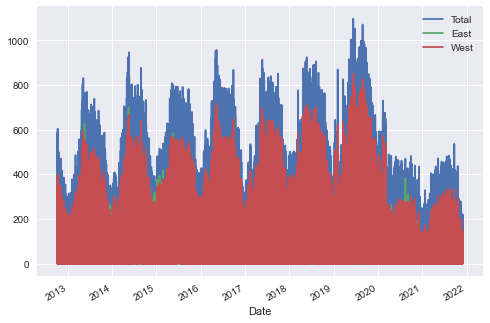

In [27]:
data.plot();

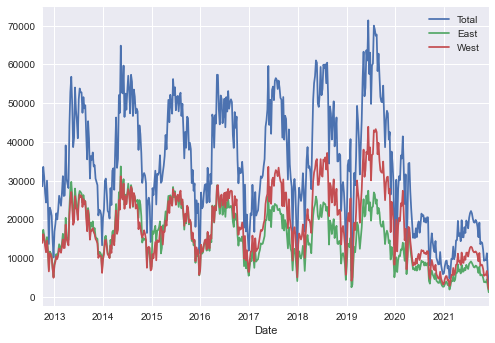

In [28]:
# since the data is so dense, can reduce it by resampling to counts for the week instead 
# of individual days
data.resample('W').sum().plot();

# Part 2

In [29]:
# How to do a rolling average for 365 days
resample = data.resample('D').sum().rolling(365).mean()

# drops the first 365 days of data since they don't have a years worth of data to average
resample.dropna(inplace=True)    
resample = resample.astype('int32')
resample.head(3)

,Total,East,West
Date,,,
2013-10-02,4942,2546,2395
2013-10-03,4940,2546,2394
2013-10-04,4939,2546,2393


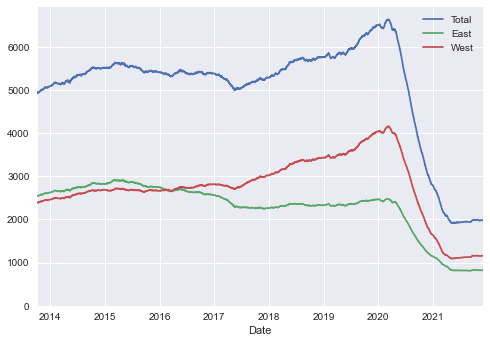

In [30]:
ax = resample.plot();
ax.set_ylim(0, None); # None means use the current maximum

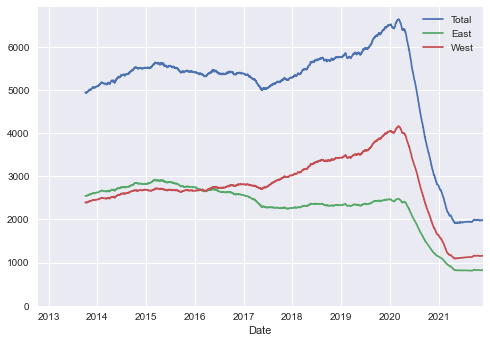

In [31]:
# How to do a rolling average directly
ax = data.resample('D').sum().rolling(365).mean().plot();
ax.set_ylim(0, None);  # None means use the current maximum

In [46]:
data.index.time

array([datetime.time(0, 0), datetime.time(1, 0), datetime.time(2, 0), ...,
       datetime.time(21, 0), datetime.time(22, 0), datetime.time(23, 0)],
      dtype=object)

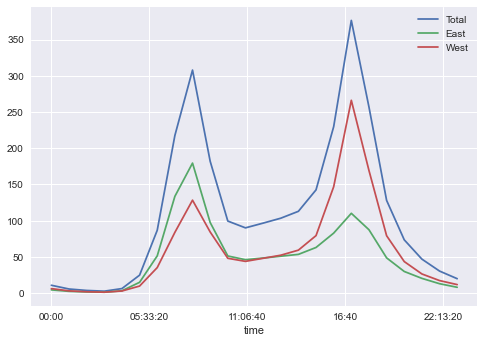

In [32]:
hourly_data  = data.groupby(data.index.time).mean()
# data.index.time pulls out just the hour from the index - can also use date, year, 
# month, day, hour, minute, or second to get those portions of the data from the index.

hourly_data.plot();

In [33]:
# pivot so that it's hours for rows and days for columns - tell it to use the 
# 'Total' column, not East or West
pivoted = data.pivot_table('Total', index=data.index.time, columns=data.index.date)
print(pivoted.shape)
pivoted.iloc[:5,:5]   # look at just the first 5x5 block of the data

(24, 3345)


,2012-10-03,2012-10-04,2012-10-05,2012-10-06,2012-10-07
00:00:00,13.0,18.0,11.0,15.0,11.0
01:00:00,10.0,3.0,8.0,15.0,17.0
02:00:00,2.0,9.0,7.0,9.0,3.0
03:00:00,5.0,3.0,4.0,3.0,6.0
04:00:00,7.0,8.0,9.0,5.0,3.0


<AxesSubplot:xlabel='time'>

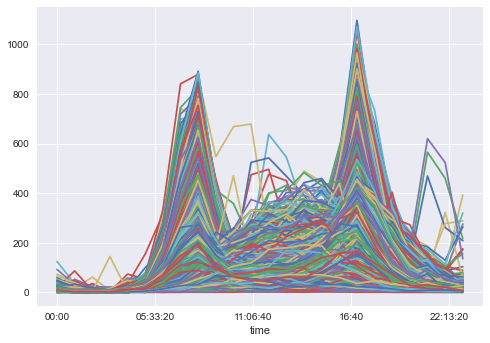

In [34]:
pivoted.plot(legend=False)

<AxesSubplot:xlabel='time'>

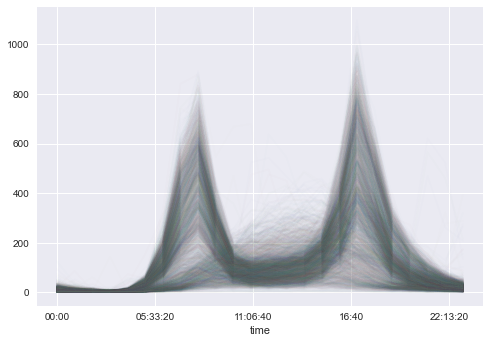

In [35]:
pivoted.plot(legend=False, alpha=0.01)

# Part 3

### Git version control when working in Jupyter Lab

- Generally a good idea to restart the kernel and run all to be sure that the code is in the proper order

His workflow
1. Initiate the project folder on GitHub
2. Clone the project into a new local folder<br>
    
```bash
$ gh repo clone robbdunlap/jakevdp_example
```
    * He used SSH but I prefer to use GitHub CLI - I installed the tool using Homebrew

3. Move existing notebook into the new folder
4. git status to see the new notebook is present<br>

```bash
$ git status
```

5. git add to stage the notebook to be added to git control<br>

```bash
$ git add unsupervised_learning.ipynb
```

6. git commit to finalize that the notebook is now under git control<br>

```bash
$ git commit -m "added lda analysis"
```

    * the <-m> indicates that the following string is the commit comment
    
7. "git push"<br>

```bash
$ git push origin main 
```

    * For my first attempt I had changes on GitHub that weren't merged with my local copy (I had manually edited the readme on GitHub). These had to be merged locally before pushing the notebook. I first had to do "Git Pull". This popped me into Vi editor. "I" switches from command mode into insert. Enter the necessary text and then hit "esc" to get back to command mode. Typing a colon will drops you to the bottom of the screen where you can enter file related commands. Typing x or wq followed by return will save the file and quit Vi. Can quit Vi by typing q instead but this won't save the changes you've made. I found some relevant Vi instructions here - https://www.cs.colostate.edu/helpdocs/vi.html. After editing the merge comments I then entered "git commit", had to make further comments in Vi, and then "git push" - I didn't need to append "origin main".
    
    
* Can check status and what branch you are on with the "git status" at any time.

# Part 4

```bash
$ git status --ignore
```

This will show at the command line what's listed in the .ignore file. However, it's much simpler just to open the project folder in VSCode and view edit the .ignore file there.

Add a section at the bottom of the file for data. Since the data for this project is stored in the "data" folder then just add the folder location to the .gitignore - there are size limits to the amount of data you can store on GitHub. It's better to provide links to the data rather than the actual data (hence the function above that will download the data from the API if it's not already in the project data folder on the users computer.

```python
# data
data/
```